In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

import model_functions as mf

MF reloaded 1


In [2]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def logit(p):
    return np.log(p/(1-p))

def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


In [4]:
%%time
with pd.HDFStore('out/ModelData.pmc_pair.h5') as cstore:
    df_first = cstore["first_author"]
    df_last = cstore["last_author"]
    df_middle_2nd = cstore["middle_2nd_author"]

CPU times: user 32.2 s, sys: 12.9 s, total: 45.1 s
Wall time: 45.1 s


## Modelling

In [5]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ I(source_ncites == 1) + np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

models = dict()

### First author

In [6]:
y,X = patsy.dmatrices(formula, data=df_first, return_type="dataframe")
print X.shape, y.shape

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
(4837856, 69) (4837856, 1)


In [7]:
print("X columns: {}".format(X.columns))
print("y columns: {}".format(y.columns))

X columns: Index([u'Intercept', u'I(auth_prev_papers == 0)[T.True]',
       u'I(auth_prev_papers == 1)[T.True]', u'C(gender, levels=GENDERS)[T.F]',
       u'C(gender, levels=GENDERS)[T.M]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
       u'C(source_country, levels=TOP_15

In [8]:
model = Logit(y,X)
res = model.fit(method="lbfgs", maxiter=100)
res.summary2()

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
=====================================================================================================================
Model:                                Logit                            Pseudo R-squared:                 0.202       
Dependent Variable:                   is_self_cite                     AIC:                              1429880.2701
Date:                                 2017-12-21 14:34                 BIC:                              1430804.3168
No. Observations:                     4837856                          Log-Likelihood:                   -7.1487e+05 
Df Model:                             68                               LL-Null:                          -8.9555e+05 
Df Residuals:                         4837787                          LLR p-value:                      0.0000      
Converged:                            0.0000                           Scale:                            1.0000      
---------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.6005   0.3778  -1.5897 0.1119 -1.3410  0.1399
I(auth_prev_papers == 0)[T.True]                                     -1.7591   0.0250 -70.5049 0.0000 -1.8080 -1.7102
I(auth_prev_papers == 1)[T.True]                                     -0.3716   0.0126 -29.4419 0.0000 -0.3963 -0.3469
C(gender, levels=GENDERS)[T.F]                                       -0.0423   0.0098  -4.3342 0.0000 -0.0614 -0.0232
C(gender, levels=GENDERS)[T.M]                                       -0.0257   0.0091  -2.8123 0.0049 -0.0436 -0.0078
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                 0.1366   0.0217   6.3032 0.0000  0.0941  0.1791
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0865   0.0085 -10.1432 0.0000 -0.1032 -0.0698
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.3717   0.0181  20.5676 0.0000  0.3363  0.4071
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0572   0.0127   4.5157 0.0000  0.0324  0.0821
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0413   0.0153  -2.7034 0.0069 -0.0712 -0.0114
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.0051   0.0210   0.2424 0.8085 -0.0361  0.0463
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0773   0.0124  -6.2491 0.0000 -0.1015 -0.0530
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.7592   0.0341 -22.2917 0.0000 -0.8259 -0.6924
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0697   0.0160   4.3661 0.0000  0.0384  0.1009
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1088   0.0212  -5.1423 0.0000 -0.1503 -0.0673
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.0124   0.0218  -0.5708 0.5681 -0.0552  0.0303
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.1060   0.0212   4.9996 0.0000  0.0644  0.1475
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0728   0.0371  -1.9600 0.0500 -0.1455  0.0000
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.0015   0.0083  -0.1842 0.8539 -0.0179  0.0148
I(source_ncites == 1)[T.True]                                        -0.0582   0.1193  -0.4882 0.6254 -0.2921  0.1756
I(source_n_authors > 20)[T.True]                                     -0.1126   0.0334  -3.3729 0.0007 -0.1780 -0.0472
I(source_n_mesh_ex == 0)[T.True]                                     -0.6486   0.0389 -16.6947 0.0000 -0.7247

In [9]:
models["first"] = res.summary2().tables[1]

## Last author

In [10]:
from IPython.display import display

In [11]:
y,X = patsy.dmatrices(formula, data=df_last, return_type="dataframe")
print X.shape, y.shape
model = Logit(y,X)
res = model.fit(method="lbfgs", maxiter=100)
display(res.summary2())
models["last"] = res.summary2().tables[1]

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
(4837856, 69) (4837856, 1)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.095       
Dependent Variable:                  is_self_cite                      AIC:                               2977677.0283
Date:                                2017-12-21 14:47                  BIC:                               2978601.0750
No. Observations:                    4837856                           Log-Likelihood:                    -1.4888e+06 
Df Model:                            68                                LL-Null:                           -1.6455e+06 
Df Residuals:                        4837787                           LLR p-value:                       0.0000      
Converged:                           0.0000                            Scale:                             1.0000      
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.8302   0.2483   -3.3438 0.0008 -1.3168 -0.3436
I(auth_prev_papers == 0)[T.True]                                     -1.4724   0.0370  -39.8006 0.0000 -1.5450 -1.3999
I(auth_prev_papers == 1)[T.True]                                     -0.6825   0.0316  -21.5712 0.0000 -0.7445 -0.6205
C(gender, levels=GENDERS)[T.F]                                        0.0407   0.0081    5.0355 0.0000  0.0248  0.0565
C(gender, levels=GENDERS)[T.M]                                        0.0112   0.0073    1.5338 0.1251 -0.0031  0.0256
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0497   0.0172   -2.8854 0.0039 -0.0834 -0.0159
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.1367   0.0057  -23.8771 0.0000 -0.1480 -0.1255
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                  -0.1015   0.0164   -6.2042 0.0000 -0.1336 -0.0695
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.0633   0.0083   -7.6613 0.0000 -0.0795 -0.0471
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.1266   0.0101  -12.5374 0.0000 -0.1464 -0.1068
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.2909   0.0144  -20.1727 0.0000 -0.3191 -0.2626
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.1220   0.0082  -14.9332 0.0000 -0.1381 -0.1060
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.8703   0.0243  -35.7833 0.0000 -0.9179 -0.8226
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.1227   0.0113  -10.8877 0.0000 -0.1448 -0.1006
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1334   0.0144   -9.2384 0.0000 -0.1617 -0.1051
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.2662   0.0147  -18.1272 0.0000 -0.2950 -0.2374
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                 -0.1692   0.0146  -11.6235 0.0000 -0.1977 -0.1407
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.2420   0.0248   -9.7679 0.0000 -0.2906 -0.1935
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.1812   0.0058  -31.3512 0.0000 -0.1926 -0.1699
I(source_ncites == 1)[T.True]                                        -0.0033   0.1262   -0.0263 0.9790 -0.2507  0.2440
I(source_n_authors > 20)[T.True]                                     -0.0345   0.0255   -1.3512 0.1766 -0.0846  0.0156
I(source_n_mesh_ex == 0)[T.True]                                     -1.0756

## Middle 2nd author

In [12]:
y,X = patsy.dmatrices(formula, data=df_middle_2nd, return_type="dataframe")
print X.shape, y.shape
model = Logit(y,X)
res = model.fit(method="lbfgs", maxiter=100)
display(res.summary2())
models["middle_2nd"] = res.summary2().tables[1]

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
(4123573, 69) (4123573, 1)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
=====================================================================================================================
Model:                                Logit                            Pseudo R-squared:                 0.183       
Dependent Variable:                   is_self_cite                     AIC:                              1088070.4513
Date:                                 2017-12-21 15:00                 BIC:                              1088983.4752
No. Observations:                     4123573                          Log-Likelihood:                   -5.4397e+05 
Df Model:                             68                               LL-Null:                          -6.6559e+05 
Df Residuals:                         4123504                          LLR p-value:                      0.0000      
Converged:                            0.0000                           Scale:                            1.0000      
---------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.6314   0.4189  -1.5074 0.1317 -1.4525  0.1896
I(auth_prev_papers == 0)[T.True]                                     -2.0046   0.0283 -70.8070 0.0000 -2.0601 -1.9492
I(auth_prev_papers == 1)[T.True]                                     -0.4819   0.0162 -29.7470 0.0000 -0.5137 -0.4502
C(gender, levels=GENDERS)[T.F]                                       -0.0174   0.0115  -1.5223 0.1279 -0.0399  0.0050
C(gender, levels=GENDERS)[T.M]                                       -0.0397   0.0108  -3.6769 0.0002 -0.0608 -0.0185
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                 0.1289   0.0274   4.7015 0.0000  0.0752  0.1826
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0689   0.0101  -6.8408 0.0000 -0.0887 -0.0492
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2423   0.0189  12.7941 0.0000  0.2052  0.2795
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.0030   0.0144  -0.2118 0.8322 -0.0312  0.0251
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0411   0.0160  -2.5702 0.0102 -0.0725 -0.0098
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.0419   0.0230   1.8195 0.0688 -0.0032  0.0870
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0994   0.0148  -6.7124 0.0000 -0.1284 -0.0704
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -1.1022   0.0387 -28.4959 0.0000 -1.1780 -1.0264
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0479   0.0183   2.6201 0.0088  0.0121  0.0837
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   0.2258   0.0214  10.5710 0.0000  0.1840  0.2677
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.1134   0.0229  -4.9547 0.0000 -0.1583 -0.0686
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0484   0.0229   2.1114 0.0347  0.0035  0.0933
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0875   0.0455  -1.9236 0.0544 -0.1766  0.0017
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.0025   0.0094  -0.2659 0.7903 -0.0209  0.0159
I(source_ncites == 1)[T.True]                                        -0.0198   0.1571  -0.1257 0.8999 -0.3277  0.2882
I(source_n_authors > 20)[T.True]                                     -0.0499   0.0401  -1.2443 0.2134 -0.1284  0.0287
I(source_n_mesh_ex == 0)[T.True]                                     -0.8412   0.0468 -17.9734 0.0000 -0.9329

## All models combined

In [13]:
df_all_models = pd.concat(models, axis=1)
with pd.option_context("display.max_rows", 100):
    display(df_all_models.swaplevel(0, 1, axis=1).sortlevel(0, axis=1)["Coef."])

,first,last,middle_2nd
Intercept,-0.600544,-0.830171,-0.631439
I(auth_prev_papers == 0)[T.True],-1.759144,-1.472440,-2.004641
I(auth_prev_papers == 1)[T.True],-0.371589,-0.682524,-0.481945
"C(gender, levels=GENDERS)[T.F]",-0.042276,0.040673,-0.017445
"C(gender, levels=GENDERS)[T.M]",-0.025673,0.011231,-0.039690
"C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]",0.136621,-0.049685,0.128901
"C(source_country, levels=TOP_15_COUNTRIES)[T.UK]",-0.086458,-0.136738,-0.068932
"C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]",0.371681,-0.101539,0.242346
"C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]",0.057229,-0.063277,-0.003040
"C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]",-0.041274,-0.126635,-0.041148


## Plot empirical relations for each gender

In [14]:
def plot_empirical_main_features(df):
    colors = ["r", "b", "k"]
    markers = ["o", "^", "s"]
    conditioning_names = ["F", "M", "-"]
    cm = plt.cm.get_cmap('Greys')
    plt.clf()
    plt.close("all")
    fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
    ax = ax.flatten()
    plot_id = 0
    y_feature_col = "is_self_cite"
    xcols = ["auth_prev_papers", "sink_prev_ncites", 
             "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
             "year_span", "source_ncites", "source_n_authors"]
    for k in xcols:
        if k in ["auth_prev_papers", "sink_prev_ncites", "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim"]:
            bins = np.array([-0.1] + range(100) + range(100,1000,100))
            xscale = "symlog"
            xlims = [0, 1000]
        if k in ["source_ncites"]:
            bins = np.array(range(-1,100) + range(100,1000,100))
            xscale = "log"
            xlims = [1, 1000]
        if k in ["source_n_authors"]:
            bins = np.array(range(-1,100) + range(100,1000,100))
            xscale = "log"
            xlims = [1, 50]
        if k in ["year_span"]:
            bins = np.array([-10, -1] + range(100))
            xscale = "symlog"
            xlims = [-1, 100]
        print k
        t = get_empirical_logit(df, k, y_feature_col,
        conditioning_var="gender",
        bins=bins,
        testing=False)
        t_logit = logit(t["mean"]).clip(-10,10)
        lgd_items = []
        for j,c in enumerate(conditioning_names):
            scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                      facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
            line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                     marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
            lgd_items.append(line)
        ax[plot_id].set_xlabel(k)
        ax[plot_id].set_ylabel("$logit(p)$")
        ax[plot_id].set_title(k)
        ax[plot_id].set_xscale(xscale)
        ax[plot_id].set_xlim(xlims)
        ax[plot_id].set_ylim((-6,0.5))
        plot_id += 1
    plt.margins(0.1)
    #ax.legend(handles=lgd_items, loc="upper center", ncol=3)
    lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                     loc = 'upper center',
                     bbox_to_anchor=(0.5,1.1), ncol=3,
                     frameon=True, fancybox=True, prop={"size": 16})
    fig.tight_layout()

auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


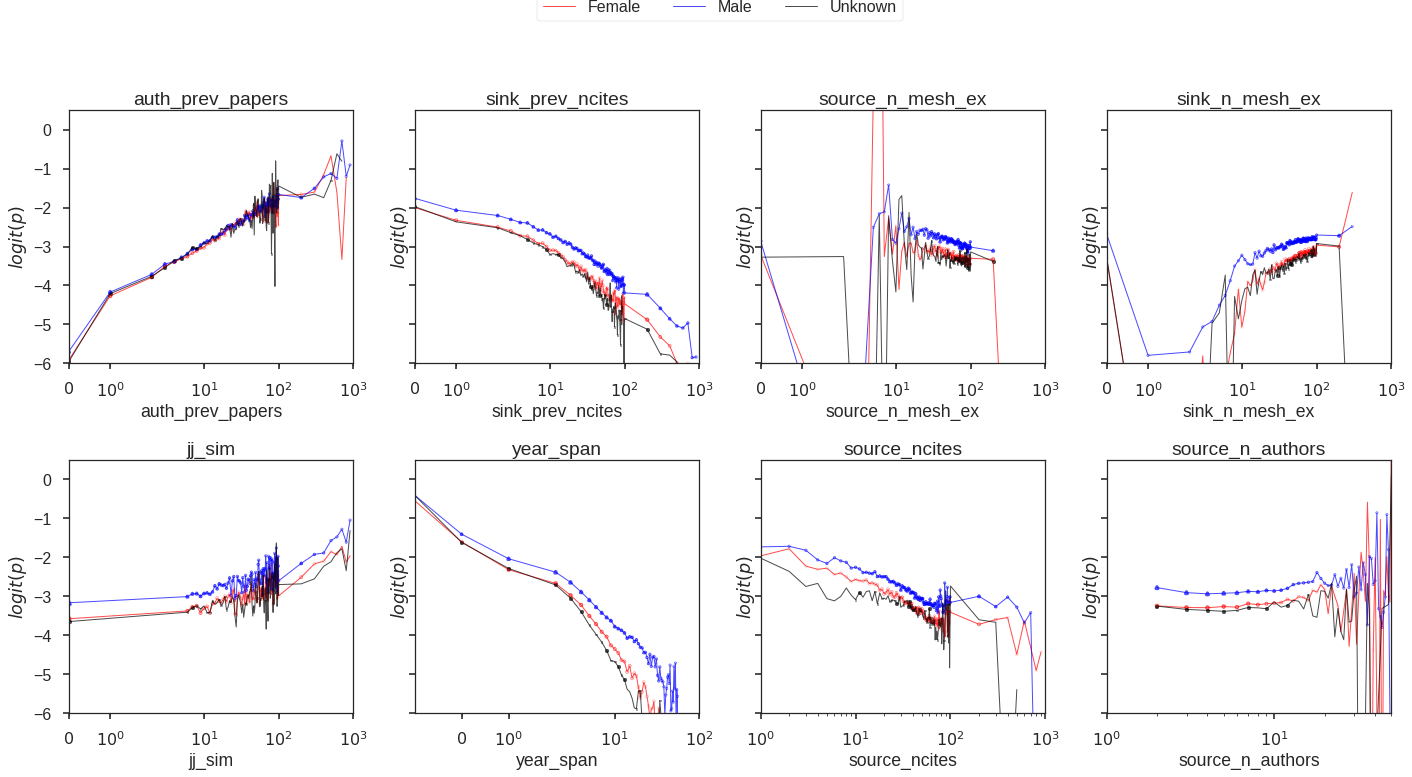

In [15]:
plot_empirical_main_features(df_first)

auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


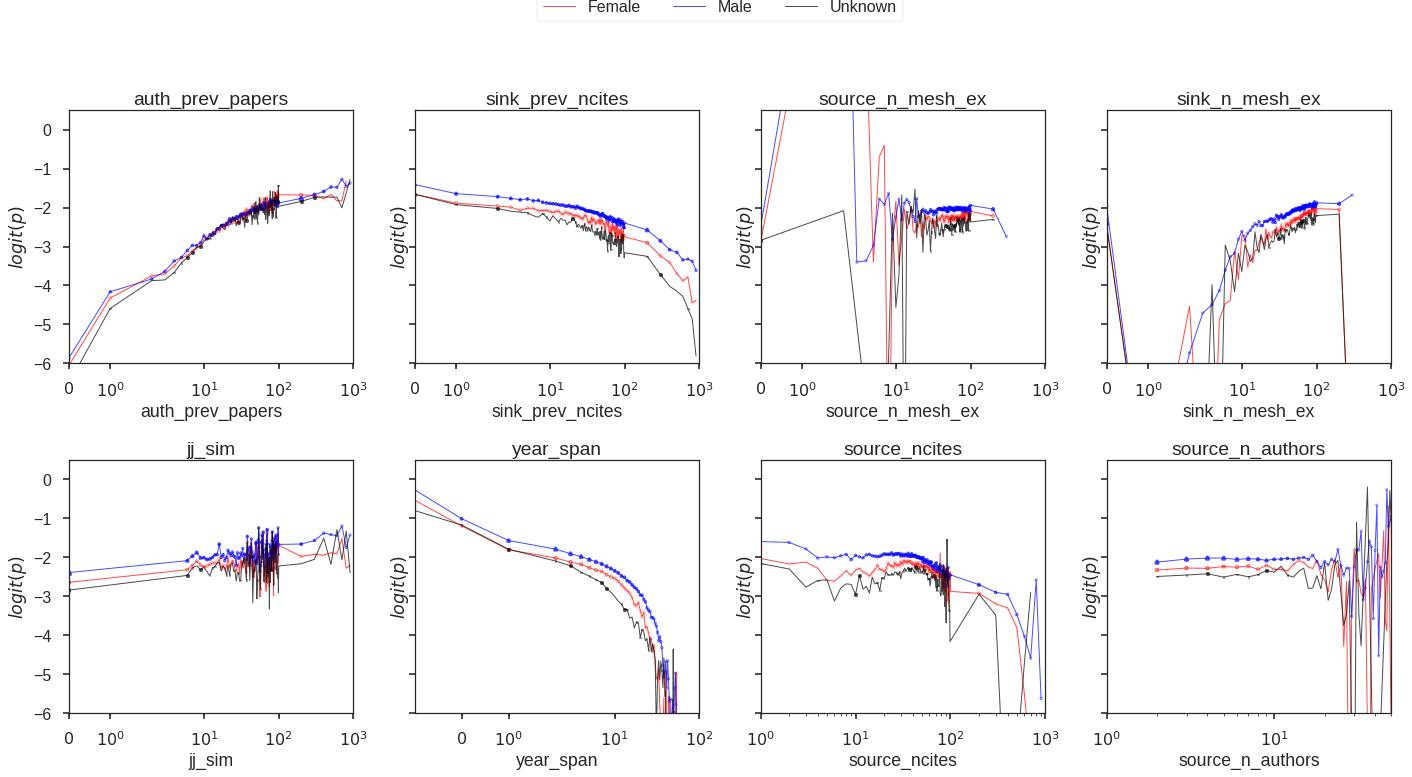

In [16]:
plot_empirical_main_features(df_last)

auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


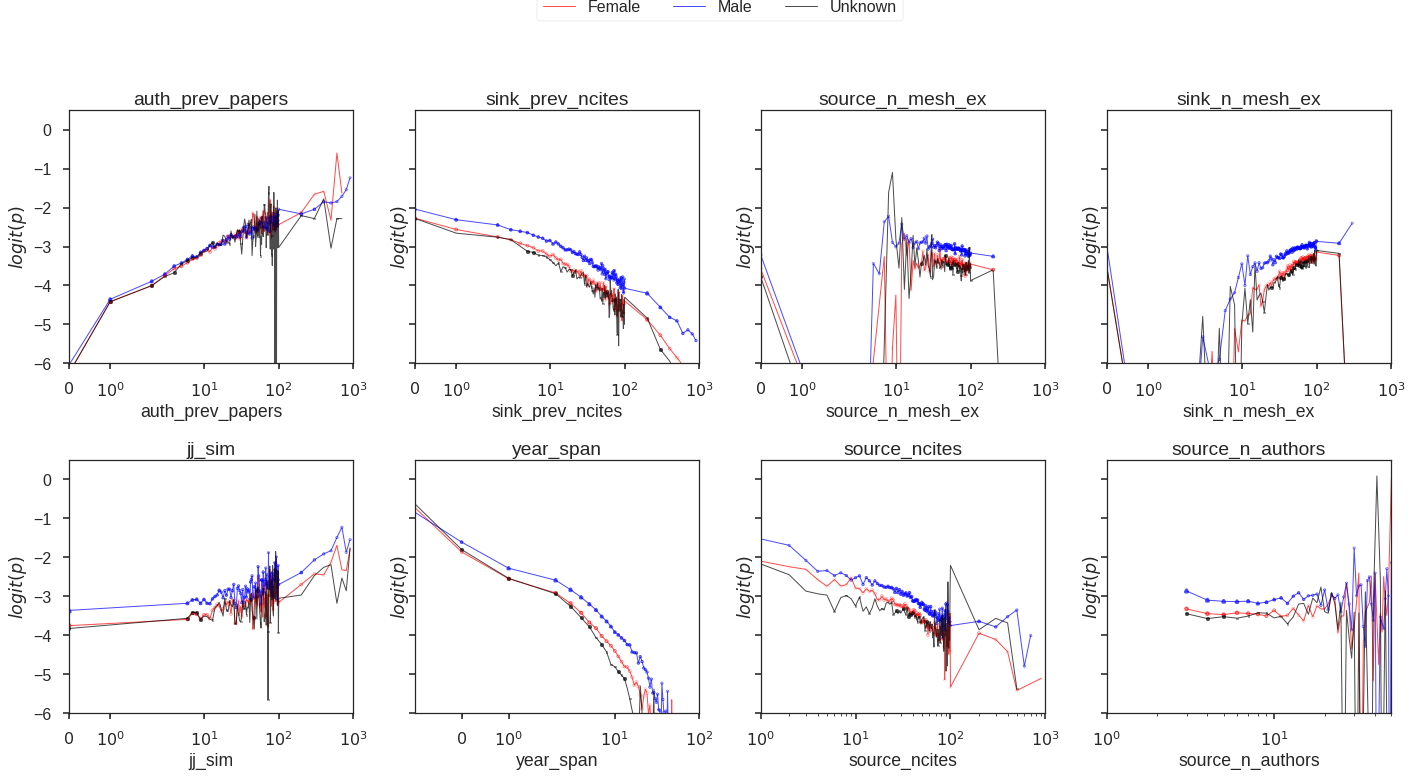

In [17]:
plot_empirical_main_features(df_middle_2nd)

## Plot filtered models

In [18]:
def filtered_data(df):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=60)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered


markersize=3
linestyle="-"
linewidth=0.5
gender_params={
    "F": dict(
        label="Female",
        color="crimson",
        marker="o",
    ),
    "M": dict(
        label="Male",
        color="dodgerblue",
        marker="s",
    ),
    
}
genders = ["F", "M"]

plot_params=dict(
    markersize=markersize,
    capsize=0.5, elinewidth=0.01,
    alpha=0.6,
    linestyle="none"
)

In [20]:
def model_predictions(df, formula, df_test, verbose=False, model_params=None):
    if model_params is None:
        model_params = dict()
    if verbose:
        print(df.shape, df_test.shape, formula)
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    if verbose:
        print "Created dataframes"
        print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X).fit(disp=verbose,
                           method='lbfgs',
                           maxiter=100,
                           **model_params
                          )
    if verbose:
        display(model.summary2())
    _, X_test = patsy.dmatrices(formula, data=df_test, return_type="dataframe")
    if verbose:
        print X_test.shape
    y_test = model.predict(X_test)
    return y_test, model


def get_age_self_cite_data(df_t_data):
    df_t = df_t_data.groupby(
        ["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
    df_t_full = df_t_data.assign(
        auth_prev_papers=np.log10(df_t_data["auth_prev_papers"] + 1).copy()
    ).groupby("gender")[["auth_prev_papers", "is_self_cite"]].agg([np.mean, np.std, len])
    df_t_full[("auth_prev_papers", "error")] = df_t_full[("auth_prev_papers", "std")] / np.sqrt(df_t_full[("auth_prev_papers", "len")])
    df_t_full[("is_self_cite", "error")] = np.sqrt(
        ((df_t_full[("is_self_cite", "mean")]
          * (1-df_t_full[("is_self_cite", "mean")])
         )/df_t_full[("is_self_cite", "len")]))
    df_t_full[("auth_prev_papers", "l_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] - df_t_full[("is_self_cite", "error")]) - 1
    df_t_full[("auth_prev_papers", "u_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] + df_t_full[("is_self_cite", "error")]) - 1
    df_t_full = df_t_full.sort_index(level=0, axis=1)
    
    error = np.sqrt(df_t["mean"].multiply(1 - df_t["mean"]).divide(df_t["len"]))
    return df_t, df_t_full, error


def plot_age_vs_self_cite(axi, df_t_data, df_t, df_t_full, error, gender,
                          gender_params, plot_params, model_params,
                          formula, df_test, error_plot=True,
                          mean_line=False, verbose=False):
    """
    TODO: Add beta of Male Female indicator to the plot. 
    """
    error_params = gender_params[gender]
    if error_plot:
        axi.errorbar(df_t.index.values, df_t["mean"][gender].values,
                     yerr=error[gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **plot_params
                    )
    else:
        axi.plot(df_t.index.values, df_t["mean"][gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **dict([(k,v)
                         for k,v in plot_params.items()
                         if k not in set(["capsize", "elinewidth"])
                     ])
                    )

    x_mean = 10**(df_t_full.ix[gender, [("auth_prev_papers", "mean")]].values)-1
    y_mean = df_t_full.ix[gender, [("is_self_cite", "mean")]].values
    y_mean_err = df_t_full.ix[gender, [("is_self_cite", "error")]].values
    if mean_line:
        axi.axhline(
            y=y_mean[0],
            color=gender_params[gender]["color"],
            label="{} ({:.2f}% self-citations)".format(
                gender_params[gender]["label"], y_mean[0]*100),
            linestyle="--",
            lw=linewidth+1
        )
    else:
        axi.errorbar(
            x_mean, y_mean,
            #xerr=[df_t_full[("auth_prev_papers", "l_error")].values,
            #      df_t_full[("auth_prev_papers", "u_error")].values],
            yerr=y_mean_err,
            color=gender_params[gender]["color"],
            marker=gender_params[gender]["marker"],
            label="{}(x={:.2f},y={:.2f})".format(
                gender_params[gender]["label"], x_mean[0], y_mean[0]*100),
            ms=10,
        )

    print "Fitting model for %s" % gender
    model = None
    try:
        y_test, model = model_predictions(
                df_t_data,
                formula, df_test, verbose=verbose, model_params=model_params)
        axi.plot(df_test["auth_prev_papers"], y_test,
                 color=gender_params[gender]["color"],
                 linestyle="-",
                 linewidth=linewidth
                )
    except:
        print("Modeling failed.")
        print(df_t_data[df_t_data.auth_prev_papers < 2].auth_prev_papers.value_counts())
        import traceback
        traceback.print_exc()
    return axi, model

def plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=False):
    # Plot distribution
    y = (df_t["len"][gender] * 1./ df_t["len"][gender].sum())
    if cdf:
        y = y.cumsum()
    axi_dist.plot(df_t.index, y,
                  color=gender_params[gender]["color"],
                  label=gender_params[gender]["label"],
                  marker=gender_params[gender]["marker"],
                  linestyle="-",
                  alpha=0.5,
                  markersize=markersize
    )
    return axi_dist

In [21]:
df_t_first = filtered_data(df_first)
df_t_last = filtered_data(df_last)
df_t_middle_2nd = filtered_data(df_middle_2nd)

(3176320, 57) (4837856, 57)
Filter dataset is 65.66% of the original data.
(3422430, 57) (4837856, 57)
Filter dataset is 70.74% of the original data.
(2821420, 57) (4123573, 57)
Filter dataset is 68.42% of the original data.


Fitting model for F
Fitting model for M
Fitting model for F
Fitting model for M
Fitting model for F
Fitting model for M
CPU times: user 16min 30s, sys: 1min 7s, total: 17min 38s
Wall time: 7min 13s


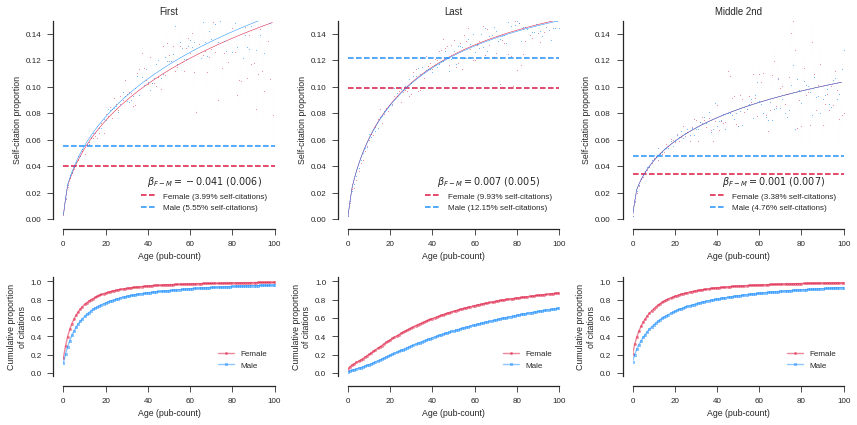

In [22]:
%%time
sns.set_context("paper")
formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
               "+ I(auth_prev_papers == 1)"
               "+ C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
              )

fig, ax = plt.subplots(
    nrows=2, ncols=3,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios': [2, 1]},
    figsize=(12,6))
paper_filter = 100

for i, (df_t_data, title) in enumerate(zip(
        [df_t_first, df_t_last, df_t_middle_2nd],
        ["First", "Last", "Middle 2nd",],
    )):
    axi, axi_dist = ax[:, i].flatten()
    #df_t_data = df_t_data[(df_t_data.auth_prev_papers <= paper_filter)]
        
    df_t, df_t_full, error = get_age_self_cite_data(df_t_data)
    for j, gender in enumerate(genders):
        df_test = pd.DataFrame({
                    "auth_prev_papers": np.arange(0,min([paper_filter, 150]))
                }).assign(is_self_cite=1, gender=gender)
        model_params = dict()
        axi, model = plot_age_vs_self_cite(axi,
                                    df_t_data, #[df_t_data.gender == gender],
                                    df_t, df_t_full, error, gender,
                                    gender_params, {
                                        k: (1 if k == "markersize" else v)
                                        for k,v in plot_params.items()
                                    }, model_params,
                                    formula, df_test, mean_line=True, verbose=False)
        axi_dist = plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=True)
        legend_title = ""
        if model:
            model_stats = model.summary2().tables[1].ix[
                "C(gender, levels=['M', 'F'])[T.F]",
                ["Coef.", "Std.Err."]].values
            legend_title = "$\\beta_{F-M}=%.3f\ (%.3f)$" % (model_stats[0], model_stats[1])
    axi.set_ylim([0, 0.15])
    axi.set_xlim([0, 100])
    axi.set_title(title)
    axi.set_xlabel("Age (pub-count)")
    axi.set_ylabel("Self-citation proportion")
    axi.legend(loc='lower right', title=legend_title)

    axi_dist.legend(loc='lower right')
    axi_dist.set_xlabel("Age (pub-count)")
    axi_dist.set_ylabel("Cumulative proportion\nof citations")
    
#ax.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("PMC_PAIR_Analysis/Author_papers_self_cite_gender.pdf", bbox_inches="tight")

## Plot model data

In [23]:
formula_y = "is_self_cite"
formula_items = {
	"AuthorAge": ["I(auth_prev_papers == 0)", "I(auth_prev_papers == 1)",
		"np.log10(auth_prev_papers + 1)", #"I(np.log10(auth_prev_papers + 1)**2)"
                 ],
	"Gender": ["C(gender, levels=GENDERS)"],
	"Affiliation": ["C(source_country, levels=TOP_15_COUNTRIES)"],
	"Ethnicity": ["mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"],
	"SourceCites": ["I(source_ncites == 1)", "np.log10(source_ncites)",
		"I(np.log10(source_ncites)**2)", "I(np.log10(source_ncites)**3)"],
	"SourceAuthors": ["I(source_n_authors > 20)", "np.log10(np.clip(source_n_authors, 0, 20))",
		"I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"],
	"MeshCounts": ["np.log10(source_n_mesh_ex + 1)", "I(source_n_mesh_ex == 0)",
		"np.log10(sink_n_mesh_ex + 1)", "I(sink_n_mesh_ex == 0)"],
	"YearSpan": ["I(year_span < 0)", "I(year_span == 0)",
		"mf.score_log_1(year_span)", "I(mf.score_log_1(year_span)**2)"],
	"SinkCites": ["I(sink_prev_ncites == 0)", "np.log10(sink_prev_ncites + 1)",
		"I(np.log10(sink_prev_ncites + 1)**2)"],
	"Journal": ["I(jj_sim == 0)", "np.log10(jj_sim + 1)",
		"I(np.log10(jj_sim + 1)**2)", "journal_same"],
	"Language": ["source_is_eng", "sink_is_eng", ],
	"PubType": ["source_is_journal", "source_is_review", "source_is_case_rep", "source_is_let_ed_com",
           "sink_is_journal", "sink_is_review", "sink_is_case_rep", "sink_is_let_ed_com"],
	"VolumeNovelty": ["np.log10(np.nan_to_num(source_V_novelty) + 1)",
			"np.log10(np.nan_to_num(sink_V_novelty) + 1)", "I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"]
}

feature_dict = { 
	"Intercept": [u'Intercept',],
	"Gender": [
		u'C(gender, levels=GENDERS)[T.F]',
		u'C(gender, levels=GENDERS)[T.M]',
		],
	"Affiliation": [
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]',
	],
	"Ethnicity": [
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13]',
	],
	"AuthorAge": [
		u'I(auth_prev_papers == 0)[T.True]',
		u'I(auth_prev_papers == 1)[T.True]',        
		u'np.log10(auth_prev_papers + 1)',
		#u'I(np.log10(auth_prev_papers + 1) ** 2)',
	],
	"SourceCites": [
		u'I(source_ncites == 1)[T.True]',
		u'np.log10(source_ncites)',
		u'I(np.log10(source_ncites) ** 2)',
        u'I(np.log10(source_ncites) ** 3)',
	],
	"SourceAuthors": [
		u'I(source_n_authors > 20)[T.True]',
		u'np.log10(np.clip(source_n_authors, 0, 20))',
		u'I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)',
	],
	"MeshCounts": [
		u'I(source_n_mesh_ex == 0)[T.True]',
		u'I(sink_n_mesh_ex == 0)[T.True]',
		u'np.log10(source_n_mesh_ex + 1)',
		u'np.log10(sink_n_mesh_ex + 1)',
	],
	"Journal": [
		u'journal_same[T.True]',
		u'I(jj_sim == 0)[T.True]',
		u'np.log10(jj_sim + 1)',
		u'I(np.log10(jj_sim + 1) ** 2)',
	],
	"YearSpan": [
		u'I(year_span < 0)[T.True]',
		u'I(year_span == 0)[T.True]',
		u'mf.score_log_1(year_span)',
		u'I(mf.score_log_1(year_span) ** 2)',
	],
	"SinkCites": [
		u'I(sink_prev_ncites == 0)[T.True]',
		u'np.log10(sink_prev_ncites + 1)',
		u'I(np.log10(sink_prev_ncites + 1) ** 2)',       
	],
	"PubType": [
		u'source_is_journal[T.True]',
		u'source_is_review[T.True]',
		u'source_is_case_rep[T.True]',
		u'source_is_let_ed_com[T.True]',
		u'sink_is_journal[T.True]',
		u'sink_is_review[T.True]',
		u'sink_is_case_rep[T.True]',
		u'sink_is_let_ed_com[T.True]',
	],
	"Language": [
		u'source_is_eng[T.True]',
		u'sink_is_eng[T.True]',
	],
	"VolumeNovelty": [
		u'np.log10(np.nan_to_num(source_V_novelty) + 1)',
		u'np.log10(np.nan_to_num(sink_V_novelty) + 1)',
		u'I(np.log10(np.nan_to_num(sink_V_novelty) + 1) ** 2)'
	]
}


feature_short_codes={
    "AuthorAge": "PC",
    "Gender": "G",
    "Affiliation": "CA",
    "Ethnicity": "E",
    "SourceCites": "NR",
    "SourceAuthors": "NA",
    "MeshCounts": "MC",
    "YearSpan": "YS",
    "SinkCites": "CC",
    "Journal": "J",
    "Language": "L",
    "PubType": "P",
    "VolumeNovelty": "N",
    "Intercept": "O"
}



feature_xlabels={
    "AuthorAge": "age (pub count)",
    "Gender": "gender",
    "Affiliation": "country",
    "Ethnicity": "ethnicity",
    "SourceCites": "reference counts",
    "SourceAuthors": "collaboration size",
    "MeshCounts": "MeSH count",
    "YearSpan": "time lag",
    "SinkCites": "ref. citation count",
    "Journal": "journal",
    "Language": "language",
    "PubType": "publication type",
    "VolumeNovelty": "novelty",
    "Intercept": "intercept"
}

In [24]:
def extract_coeffs(
    model_df, feature, feature_dict,
    select_cols=(u'Coef.', u'Std.Err.', u'z', u'P>|z|', u'[0.025', u'0.975]'),
    filter_string=""
):
    #model_df = summary.tables[1]
    items = [k for k in feature_dict[feature] if filter_string in k]
    return model_df.ix[items, select_cols]

def gen_simulation_data(formula, x, weights, baseline_index=0, return_odds_ratio=False):
    X = patsy.dmatrix(formula, data=x, return_type="dataframe")
    X.drop('Intercept', axis=1, inplace=True)
    W = weights["Coef."].values
    y = np.dot(W, X.values.T)
    W_err_l = weights["[0.025"].values
    W_err_u = weights["0.975]"].values
    y_err = (np.dot(W_err_l, X.values.T), np.dot(W_err_u, X.values.T))
    if return_odds_ratio:
        y_baseline = y[baseline_index]
        y_err_baseline = (y_err[0][baseline_index], y_err[1][baseline_index])
        y = y - y_baseline
        y_err = (y_err[0] - y_err_baseline[0], y_err[1] - y_err_baseline[1])
    #print y.shape, y_err[0].shape, y_err[1].shape
    return x.values.flatten(), y, y_err


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def create_model_plot(ax, summary, feature, feature_dict,
                      x_col, x_range, label="First", color="r", alpha=0.2,
                      plot_odds=False,
                      filter_string = "", baseline_index=0, return_odds_ratio=False, **kwargs):
    W = extract_coeffs(summary, feature=feature, feature_dict=feature_dict, filter_string=filter_string)
    items = [k for k in formula_items[feature] if filter_string in k]
    x, y, y_err = gen_simulation_data("+".join(items), pd.DataFrame({x_col: x_range}), W,
                                     baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    if plot_odds:
        y = np.exp(y)
        y_err = (np.exp(y_err[0]), np.exp(y_err[1]))
    if feature in ["YearSpan", "Journal"]:
        ax.plot(x[:1],y[:1],#yerr=(y[:1]-y_err[0][:1], y_err[1][:1]),
                    marker="o",
                    color=color, **kwargs)
        ax.fill_between(x[:1],y_err[0][:1], y_err[1][:1],
                    color=color, alpha=alpha, **kwargs)
        x, y, y_err = x[1:], y[1:], (y_err[0][1:], y_err[1][1:])
    ax.plot(x,y, color=color, label=label, **kwargs)
    ax.fill_between(x, y_err[0], y_err[1], color=color, alpha=alpha, **kwargs)
    #print y_err[0].min(), y_err[0].max(), y_err[1].min(), y_err[1].max(), 
    return ax, (y_err[1].min(), y_err[0].max())
    #return ax, (y.min(), y.max())

In [25]:
print(list(models.keys()))

['middle_2nd', 'last', 'first']


(w.r.t. $x = 0$)
(0.20000000000000001, 1.0)
(w.r.t. $x = 1$)
(w.r.t. $x = 0.0$)
(w.r.t. $x = 5$)
(w.r.t. $x = 1$)
(0.20000000000000001, 1.4000000000000001)
(w.r.t. $x = 1$)
(0.60000000000000009, 1.0)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(1.0, 1.4000000000000001)


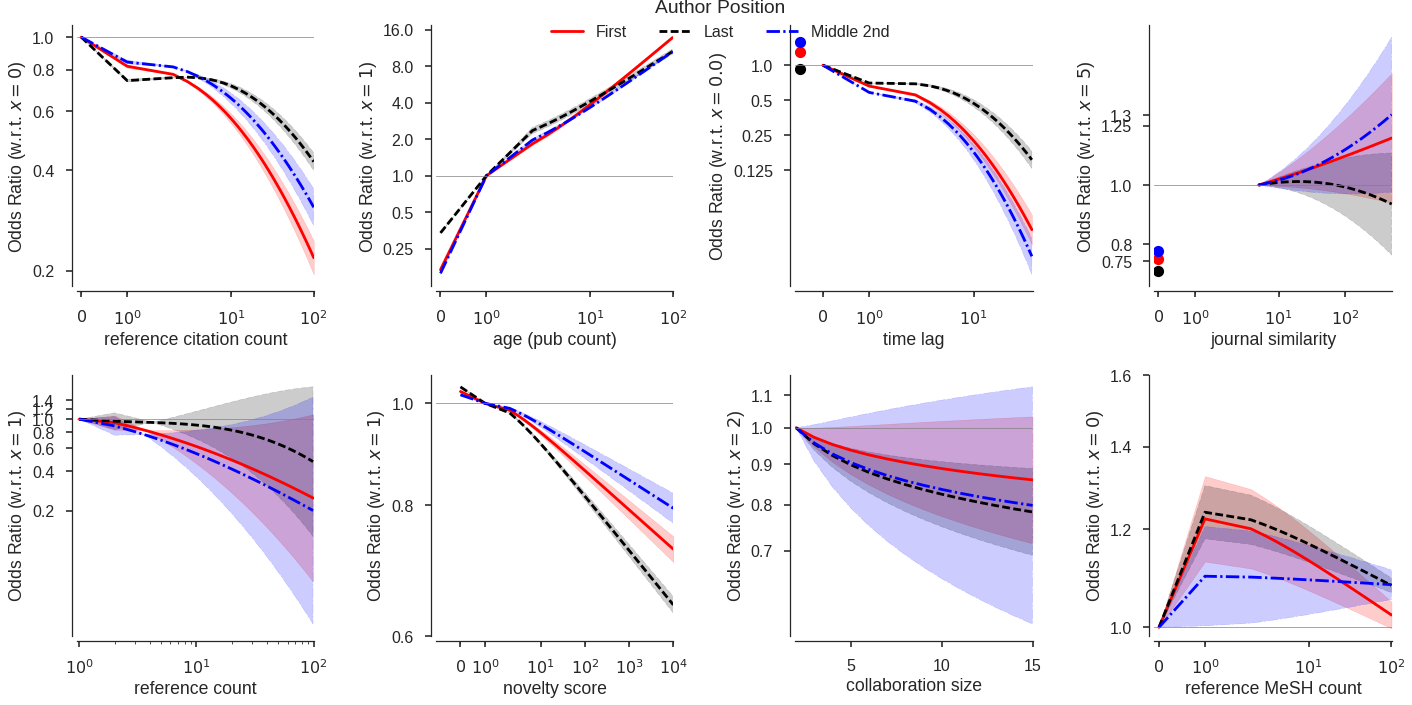

In [26]:
sns.set_context("poster")
sns.set_style("ticks")
xcols = ["SinkCites", "AuthorAge", "YearSpan", "Journal",  
         "SourceCites", "VolumeNovelty", "SourceAuthors", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "age (pub count)",
                  np.power(2.,range(-2,5))),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "collaboration size",
                     np.arange(0.7,1.1,0.1)),
    "SinkCites": ("sink_prev_ncites", np.arange(0,101), "symlog", [-0.1, 101], None, "reference citation count", None),
    "YearSpan": ("year_span", np.array([-0.5] + range(51)), "symlog", [-0.6,51], None, "time lag",
                 np.power(2.,range(-3,1))),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "novelty score", None),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "reference MeSH count", None),
    "Journal": ("jj_sim", np.array([0] + range(5,500)), "symlog", [-0.1, 501], None, "journal similarity", [0.75, 0.8, 1.0, 1.25, 1.3]),
    "SourceCites": ("source_ncites", np.arange(1,100), "log", [0.95, 101], None, "reference count", None),
}


fig, ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
colors = ["r", "k", "b"]
labels = ["First", "Last", "Middle 2nd"]
linestyles = ["-", "--", "-."]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
plot_odds=False
baseline_index = 0
baseline_y= 1 if plot_odds else 0
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl, yticks = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge", "VolumeNovelty", "Journal"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, model_key in enumerate(("first", "last", "middle_2nd")):
        create_model_plot(ax[i], models[model_key], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=plot_odds,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=baseline_y, linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    if not plot_odds:
        ylm = np.exp(ax[i].get_ylim())
        if yticks is None:
            spacing=0.2
            ticksarray = np.arange(0.2,1.6,0.2)
            ylm = find_nearest(ticksarray, ylm[0]), find_nearest(ticksarray, ylm[1])
            print ylm
            yticks = np.log(np.arange(ylm[0], ylm[1]+0.2, spacing))
        else:
            yticks = np.log(yticks)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticks)
        #ax[i].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: "%.1f" % np.exp(x)))
        ax[i].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: np.exp(x)))
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.0), ncol=3, title="Author Position",
                fancybox=True, frameon=False)

plt.savefig(
    "PMC_PAIR_Analysis/Opportunity_Visibility_coeffs.first_last_middle.OR_{}.pdf".format(plot_odds),
    bbox_inches="tight", bbox_extra_artists=[lgd]
)

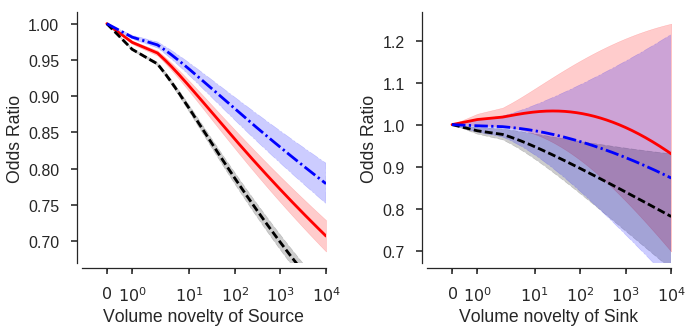

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
#colors = ["r", "k"]
#labels = ["First", "Last"]
#linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio = True

feature = "VolumeNovelty"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_V_novelty",
                                              np.arange(0,10000), "symlog", [-1,10001], None, "Volume novelty of %s")
for i, (x_col, xlbl_f) in enumerate(zip(["source_V_novelty", "sink_V_novelty"],
                                     ["Source", "Sink"])):
    for j, model_key in enumerate(("first", "last", "middle_2nd")):
        #print labels[j]
        create_model_plot(ax[i], models[model_key], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

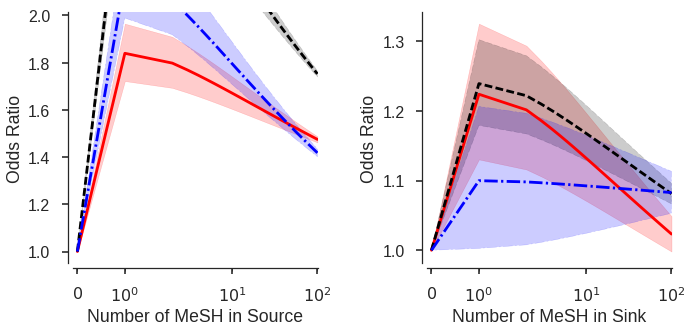

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
ylbl = "Odds Ratio"
return_odds_ratio = True

feature = "MeshCounts"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_n_mesh_ex",
                                              np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in %s")
for i, (x_col, xlbl_f) in enumerate(zip(["source_n_mesh_ex", "sink_n_mesh_ex"],
                                     ["Source", "Sink"])):
    for j, model_key in enumerate(("first", "last", "middle_2nd")):
        #print labels[j]
        create_model_plot(ax[i], models[model_key], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

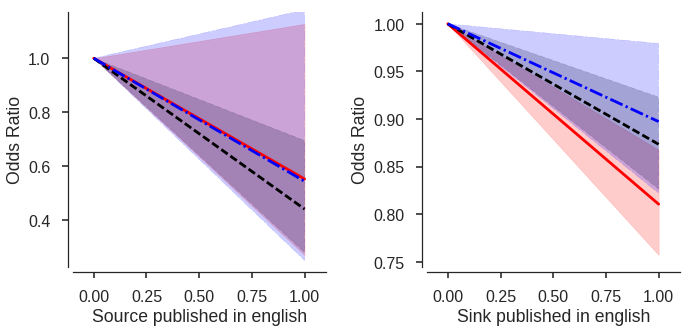

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
ylbl = "Odds Ratio"
return_odds_ratio=True

feature = "Language"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_is_eng",
                                              np.array([False, True]), "linear", [-0.1, 1.1], None, "%s published in english")
for i, (x_col, xlbl_f) in enumerate(zip(["source_is_eng", "sink_is_eng"],
                                     ["Source", "Sink"])):
    for j, model_key in enumerate(("first", "last", "middle_2nd")):
        #print labels[j]
        create_model_plot(ax[i], models[model_key], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

In [30]:
def create_model_plot_cat(ax, summary, feature, feature_dict,
                      label="First", marker="o", color="r", alpha=0.2,
                      plot_odds=False,
                      filter_string = "", offset=0, reverse=True, **kwargs):    
    W = extract_coeffs(summary, feature=feature, feature_dict=feature_dict, filter_string=filter_string)
    #display(W)
    x = W["Coef."].values
    x_err = (W["[0.025"].values, W["0.975]"].values)
    if reverse:
        x = x[::-1]
        x_err = (x_err[0][::-1], x_err[1][::-1])
    #display(pd.DataFrame({"x": x, "x_err[0]": x_err[0], "x_err[1]": x_err[1]}))
    y = np.arange(x.shape[0]) + offset
    if plot_odds:
        x = np.exp(x)
        x_err = (np.exp(x_err[0]), np.exp(x_err[1]))
    (_, caps, _) = ax.errorbar(x, y, xerr=(x - x_err[0], x_err[1] - x),
                               marker=marker, color=color, linestyle="None",
                               label=label, **kwargs)
    for cap in caps:
        cap.set_color(color)
        cap.set_markeredgewidth(1)
    return ax


def plot_categoricals_from_model(ax, feature, feature_cats, results, 
                                 #results_full_fa, results_full_la,
                                 plot_odds=True,
                                reverse=True, offset=0, xlbl="Odds Ratio w.r.t. %s", filter_string = "",
                                 indiv_models=None, xticks=None,**kwargs):
    baseline_x = 1 if plot_odds else 0
    for j, res in enumerate(results):
        if res is None:
            res = indiv_models[feature][1]
        else:
            res = res
        create_model_plot_cat(ax, res, feature, feature_dict, plot_odds=plot_odds, 
                              offset=offset, reverse=reverse, filter_string=filter_string,
                              elinewidth=1, **{k:v[j] for k,v in kwargs.iteritems()})
    ax.set_xlim(None)
    ax.set_ylim([-1, len(feature_cats)])
    plt.locator_params(nbins=4)
    ax.set_yticks(np.arange(len(feature_cats[1:])))
    ax.set_yticklabels(feature_cats[1:][::-1])
    ax.set_xlabel(xlbl % feature_cats[0])
    if not plot_odds:
        xlm = np.exp(ax.get_xlim())
        if xticks is None:
            ticksarray = np.arange(0.2,2.0,0.2)
            spacing=0.2
            xlm = find_nearest(ticksarray, xlm[0]), find_nearest(ticksarray, xlm[1])
            xticks = np.log(np.arange(xlm[0], xlm[1]+0.2, spacing))
        else:
            xticks = np.log(xticks)
        print feature, xlm
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        #strfmt = "%.1f" if np.log10(spacing) > -1 else "%.2f"
        #ax.xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: strfmt % np.exp(x)))
        ax.xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: np.exp(x)))
    ax.axvline(x=baseline_x, linestyle="-", linewidth=1, color="0.5", alpha=0.7, lw=1)
    ax.set_title(feature, fontweight="bold")
    return ax

Affiliation (0.20000000000000001, 1.6000000000000001)
Ethnicity (0.60000000000000009, 1.2)
Gender [ 0.93492595  1.06438762]
Language (0.20000000000000001, 1.2)
PubType (0.40000000000000002, 1.4000000000000001)
PubType (0.40000000000000002, 1.4000000000000001)


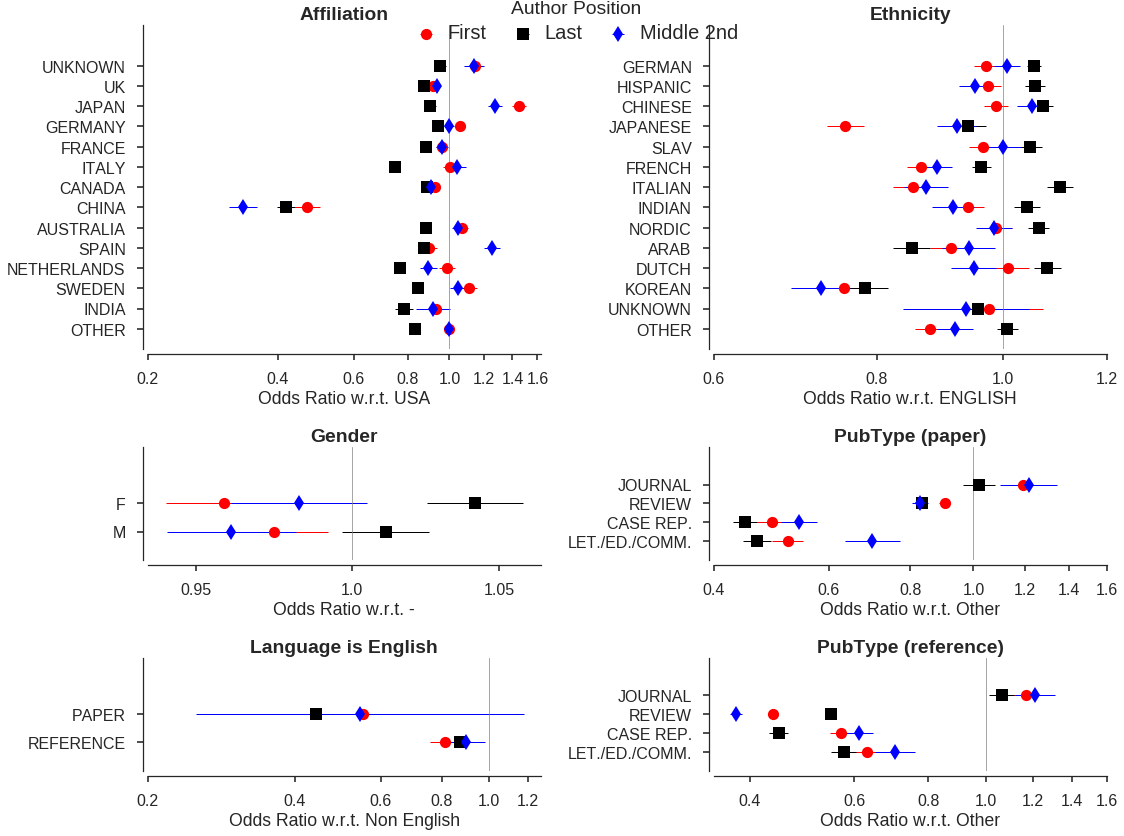

In [31]:
fig = plt.figure(figsize=(16,12))
plot_odds = False
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
#colors = ["r", "k"]
#labels = ["First", "Last"]
markers = ["o", "s", "d"]

results = (models["first"], models["last"], models["middle_2nd"])
feature="Affiliation"
feature_cats = TOP_15_COUNTRIES
ax = plt.subplot2grid((4,2), (0,0), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((4,2), (0,1), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((4,2), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                            xticks=np.arange(0.95,1.09,0.05))

feature="Language"
feature_cats = ["Non English", "PAPER", "REFERENCE"]
ax = plt.subplot2grid((4,2), (3,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="source_"
ax = plt.subplot2grid((4,2), (2,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "paper"), fontweight="bold")

filter_string="sink_"
ax = plt.subplot2grid((4,2), (3,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "reference"), fontweight="bold")

sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,0.98), ncol=3, title="Author Position",
                fancybox=True, frameon=False, prop={"size": 12})

plt.setp(lgd.get_texts(), fontsize=20)
fig.tight_layout()

plt.savefig("PMC_PAIR_Analysis/Culture_PubType_coeffs.first_last.OR_{}.pdf".format(plot_odds),
           bbox_inches="tight", bbox_extra_artists=[lgd])